# Action Recognition Using UCF101 Dataset 
**December 17, 2017 **

## Abstract
---
Here, I will be doing action recognition using **Recurrent Neural Network (RNN)**, **(Long-Short Term Memory) LSTM** in particular. In short, I would be using a pretrained but custom-defined **Convolutional Neural Network (CNN)** to extract features from the sequential data and then use LSTM to predict the action being performed in the sequential data. 

[UCF101 dataset](http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_dimitris_course.zip) is used, which consists of 101 different actions/classes and for each action, there are 145 samples which are either tagged as train or test data. Each sample consists of 25 frames from a short video. Therefore, a training sample here, is a tuple of 3D volume with one dimension encoding *temporal correlation* between frames and a label indicating what action it is.


**The goals of this project are as follows:**
* Load and **prepare the dataset** using appropriate means.
* Use a pretrained Convolutional Neural Network (VGG16 in this case) and customize it to use it as **feature extractor**.
* Capture the **spatial information** using the CNN
* Design an **LSTM based Recurrent Neural Network (RNN) Architecture** to use as a **classifier**
* Capture the **temporal information between frames** using the LSTM-based RNN
* *Train* and *test* the architecture.
* Compare the model's **accuracy** with the accuracy of Support Vector Machine (SVM) classifier for the same feature representation and **evaluate** it.


In [3]:
#importing the necessities

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random # to randomize our batch data

import torch
import torchvision
import torchvision.transforms as transforms # to transform our images # normalize
import torchvision.models as models # to import pre-trained models

from torch.autograd import Variable # let our network automatically implement back propogation
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools
from sklearn.metrics import confusion_matrix
from scipy.io import savemat # to save our features representations
from scipy.io import loadmat # to load our features representations
from sklearn import svm # to check our accuracy

import time # to record our work's time

print ('OpenCV version = ' + cv2.__version__)

OpenCV version = 3.3.0


In [4]:
# just something for the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm) # uncomment if you want to print like normal data
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# function to just plot both normalizes and normal matrix

def print_confusion_matrix(test_label, predictions, index):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

## 1. Dataset
---
The first step to any Computer Vision task is to prepare the dataset properly. In this project, I used the first class of [UCF101 dataset](http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_dimitris_course.zip). The dataset consists of the following two parts: video images and extracted features. However, we need properly extract meta-information about our dataset, load and modify the dataset accordingly and then only, extract features out of the dataset.

### 1.1. Video Images 

UCF101 dataset contains 101 actions and 13,320 videos in total.  

+ `annos/actions.txt`  
  + lists all the actions (`ApplyEyeMakeup`, .., `YoYo`)   
  
+ `annos/videos_labels_subsets.txt`  
  + lists all the videos (`v_000001`, .., `v_013320`)  
  + labels (`1`, .., `101`)  
  + subsets (`1` for train, `2` for test)  

+ `images_class1/`  
  + contains videos belonging to class 1 (`ApplyEyeMakeup`)  
  + each video folder contains 25 frames
  + Even though we have a greater number of classes, I would be **only showing the feature extraction of the first image set** that is class 1 (ApplyEyeMakeup).
  + 145 samples
  
+ `vgg16_relu6/`  
   + contains all the video features, EXCEPT those belonging to class 1 (`ApplyEyeMakeup`)  
   

---
#### 1.1.1 Functions to parse and extra meta-information about our dataset

In [6]:
# function to parse the actions.txt file to get the name of all actions
# function to parse the file whose filename is passed
# return type: data set of all the class names
def get_action_classes(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('  ')
                category.append(record[1])
    return category

In [7]:
# function to parse the videos_labels_subsets.txt file 
# to get all the labels associated with each set of video representation
#function to parse the file whose filename is passed
#return type: train,train_labels, test, test_labels
def get_video_labels(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('\t')
                row.append(record)
    return seperate_data(row) # return data set

In [8]:
# a helper function for get_video_labels(filename)
# gets the labels and tag associated with each video 
# and divides them into test and training data names and labels
#return type: train,train_labels, test, test_labels
def seperate_data(label_names):
    train = []
    test = []
    train_labels = []
    test_labels = []
    for item in label_names:
        if (item[2]=='1'):
            train.append(item[0])
            train_labels.append(int(item[1]))
        else:
            test.append(item[0])
            test_labels.append(int(item[1]))
    return train, train_labels, test, test_labels

In [9]:
# defining the path for each extraction
annotations = 'UCF101_release/annos/actions.txt'
video_annotations = 'UCF101_release/annos/videos_labels_subsets.txt'

In [11]:
class_names_all = get_action_classes(annotations) #get all action names
class_names = dict(zip(range(1, len(class_names_all)+1), class_names_all))
# change it into a dictionary for each access

print("The visual system is made to recognise the following tasks:")
[(print(x,". ", class_names[x])) for x in class_names]

# get all labels and name of training and test data features
train, train_labels, test, test_labels = get_video_labels(video_annotations)

The visual system is made to recognise the following tasks:
1 .  ApplyEyeMakeup
2 .  ApplyLipstick
3 .  Archery
4 .  BabyCrawling
5 .  BalanceBeam
6 .  BandMarching
7 .  BaseballPitch
8 .  Basketball
9 .  BasketballDunk
10 .  BenchPress
11 .  Biking
12 .  Billiards
13 .  BlowDryHair
14 .  BlowingCandles
15 .  BodyWeightSquats
16 .  Bowling
17 .  BoxingPunchingBag
18 .  BoxingSpeedBag
19 .  BreastStroke
20 .  BrushingTeeth
21 .  CleanAndJerk
22 .  CliffDiving
23 .  CricketBowling
24 .  CricketShot
25 .  CuttingInKitchen
26 .  Diving
27 .  Drumming
28 .  Fencing
29 .  FieldHockeyPenalty
30 .  FloorGymnastics
31 .  FrisbeeCatch
32 .  FrontCrawl
33 .  GolfSwing
34 .  Haircut
35 .  Hammering
36 .  HammerThrow
37 .  HandstandPushups
38 .  HandstandWalking
39 .  HeadMassage
40 .  HighJump
41 .  HorseRace
42 .  HorseRiding
43 .  HulaHoop
44 .  IceDancing
45 .  JavelinThrow
46 .  JugglingBalls
47 .  JumpingJack
48 .  JumpRope
49 .  Kayaking
50 .  Knitting
51 .  LongJump
52 .  Lunges
53 .  Milit

In [12]:
print("In total, we would have", len(train)+len(test), "number of feature representation.")
print("The size of the training set is",len(train_labels),".")
print("The size of the test set is",len(test_labels),".")
print("The number of classes in the dataset is", len(class_names),".")

In total, we would have 13320 number of feature representation.
The size of the training set is 9537 .
The size of the test set is 3783 .
The number of classes in the dataset is 101 .


### 1.2. Preparing the dataset
---
Before diving into taking out the features using VGG16, we need to prepare the dataset properly so that the features can be taken out easily.

+ If we look at the folder `images_class1/`, we have 145 samples of video frames. Each sample has 25 sequential frames/raw images of the action data.


+ Each raw image is of the size 256x340. However, VGG16 only takes in 224x224 images as input. Note: each image here has a channel of 3.
    + To tackle this, we apply the method called 5-crops which in this case, crops the data into 5 224x224 image for each raw image.
    + So, we get 5 crops (size: 224x224) at the image center and four corners.
    
    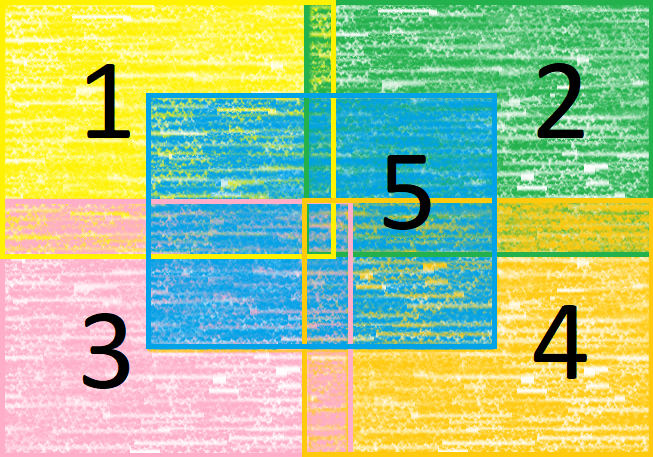
    
    + This is better than resizing because while resizing, we lose much of the information due to unfavorable changes in spatial ratio.
    + After we extract the features for each cropped image, we would take the average to get a feature representation for 1 image.




---
#### 1.2.1 Functions to modify our dataset

In [131]:
# function to show a passed image
def imshow(img):
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()

In [140]:
# function which returns a list of cropped images for a passed image
# works with images passed as normal numpy array or a tensor
# passed argument: image itself, what size you want the crops to be
# returns only a list of numpy cropped images
# uncomment to change into tensors for tensors
def get_five_crops(img, size):
    s_h, s_w = size
    crop = []
    is_tensor = torch.is_tensor(img)
    # change into a numpy array properly if it is tensor
    # Tensor image's shape -> channels*height*width
    # Numpy image's shape -> height*width*channels
    if (is_tensor):
        temp = img.numpy()
        temp = np.transpose(temp, [1, 2, 0])
        img = temp
        
    height, width, color = img.shape
    crop.append(img[0:s_h, 0:s_w]) #image 1
    crop.append(img[0:s_h, (width-s_w):width]) #image 2
    crop.append(img[(height-s_h):height, 0:s_w]) #image 3
    crop.append(img[(height-s_h):height, (width-s_w):width]) #image 4
    mid_y = int(height/2 - s_h/2)
    mid_x = int(width/2 - s_w/2)
    crop.append(img[mid_y:(mid_y + s_h), mid_x:(mid_x + s_w)]) # image 5 # center

#     uncomment to change into tensors for tensors
#     if (is_tensor):
#         for i, each in enumerate(crop):
#             crop[i] = torch.from_numpy(each.transpose(2,0,1))
    return crop 

In [17]:
# function to normalize a given image
# returns normalized tensors
def img_norm(img):
    #norm the images
    size = (224,224)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    return prep(img) #to prepare the image

In [18]:
# function which prepares the image
# first normalizes
# then extracts the 5 crops of the normalized pictures
# and returns it as a list
def prep_img(img, img_size):
    return (get_five_crops(img_norm(img), img_size))

###### Before Cropping

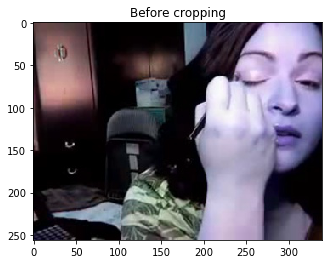

In [150]:
img = cv2.imread('UCF101_release/images_class1/v_000001/i_0001.jpg')
plt.figure()
plt.title('Before cropping')
plt.imshow(img, 'gray')
plt.show()

###### After Cropping

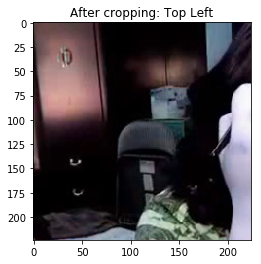

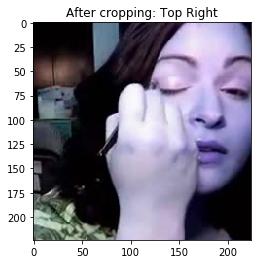

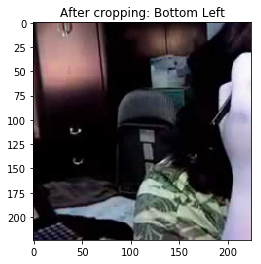

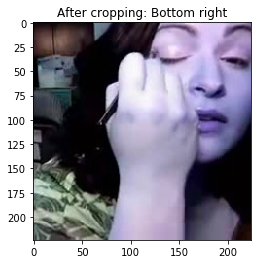

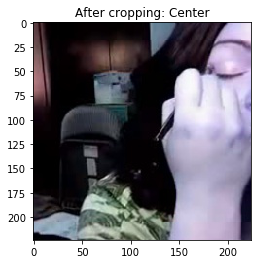

In [153]:
img_size = (224, 224)
img = cv2.imread('UCF101_release/images_class1/v_000001/i_0001.jpg')
arr = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom right', 'Center']
for i, img1 in enumerate(get_five_crops(img, img_size)):
    plt.figure()
    plt.title('After cropping: ' + arr[i])
    plt.imshow(img1, 'gray')
    plt.show()

---
#### 1.2.2 Functions to load our dataset with proper preparation/modification

In [142]:
# extracts the name of all videos for image set 1
# here 29 just represents the length of 'UCF101_release/images_class1/'
# as we need to skip that to get to the actual name of the video
vid_names = [name[29:] for name in glob.glob('UCF101_release/images_class1/*')]
vid_names = dict(zip(range(len(vid_names)), vid_names))

# ==============================================================
#    Load Data for Feature Extraction #Both Train and Test Data
# ==============================================================

def load_dataset(path, img_size, batch_num=1, is_color=False):
    data = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
    
    # read images and resizing
    for id, vid_name in vid_names.items():
        img_path_class = glob.glob(path + vid_name + '/*.jpg')
        for filename in img_path_class:
            img = cv2.imread(filename) # read the file
            crops = prep_img(img, img_size) # prepare the image
            for each in crops: # change each picture into channels*height*width
                data.append(np.transpose(each, [2, 0, 1]))
                
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        for i in range(int(len(data) / batch_num)):
            minibatch_d = np.array(data[i*batch_num: (i+1)*batch_num])
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
        data = batch_data
        
    return data


In [37]:
s = time.clock()
img_size = (224, 224)
batch_num = 5 # samples number per batch 

# load dataset for feature extraction
class1_data = load_dataset('UCF101_release/images_class1/', img_size, batch_num=batch_num, is_color=True)
class1_num = len(class1_data)
print ("Finish loading %d minibatches(=%d) of class 1 samples." % (class1_num, batch_num))
e = time.clock()

print("Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")

Finish loading 3625 minibatches(=5) of class 1 samples.
Time Taken:  1 min and 28.943727186141587 sec


---
#### 1.2.3 Summary of the prepared data
I chose each batch to be about **5 images** so that we can later **average** them easily as each 5 image of a batch corresponds to the 5 cropped images of a frame.

In [45]:
print ("The dimension of the loaded dataset is " + str(len(class1_data)) + "*"  + str(len(class1_data[0])) + "*" + str(len(class1_data[0][0])) + "*" + str(len(class1_data[0][0][0])) + "*" + str(len(class1_data[0][0][0][0])))
#3625*5*3*224*224
print("There are",str(len(class1_data)),"minibatches.")
print ("There are",str(len(class1_data[0])),"images in each minibatch.")
print ("There are",str(len(class1_data[0][0])),"channels for each image.")
print ("The shape for each image is ",str(len(class1_data[0][0][0])),"*",str(len(class1_data[0][0][0][0])))
       

The dimension of the loaded dataset is 3625*5*3*224*224
There are 3625 minibatches.
There are 5 images in each minibatch.
There are 3 channels for each image.
The shape for each image is  224 * 224


## 2. Feature extraction
---
Here, I use a pretrained VGG16 network and customize it to extract features for each cropped image of a frame. I would be using the **activation of the first fully connected (FC) layer of the torchvision.models.vgg16** model. The pretrained network was not trained to recognize any of the sequential data but was trained for about 1000 classes of ImageNet. The outer FC layers might distinguish images for object recognition but as we go to the inner layers, they are more abstract and are good at extracting edges, corners, textures, patterns and so on. Thus, by moving on to the inner fully connected layer which has 4096 dimensions, we **capture more spatial information** whereas the **sequential information** would be later captured using an **LSTM-based RNN.** 

After using the pretrained VGG network to extract 4096-dim features for each cropped image, I average the features of the 5 cropped imags to get 1 4096-dim feature from each frame. Now, as each video has about 25 frames, 
in the end, we will have a **25x4096 matrix for each video.**


### 2.1. Saving the Features
As extracting features takes a long computational time, we would be saving each of them into a .Mat file and would later load them to train our LSTM network. Here, we only extract features for class 1 data set.

---
#### 2.1.1 Functions to modify the pretrained model

In [46]:
# we use vgg16 for feature extraction
# we use the first 4096-dim as features
vgg16 = models.vgg16(pretrained=True) # takes in images of 224*224

In [47]:
print("The structure of the VGG16 model.")
print (vgg16)

The structure of the VGG16 model.
VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, ker

In [49]:
# function to modify the classifier
def change_classifier(classifier, position):
    temp_clas = list(classifier)
    temp_clas = temp_clas[0:position+1]
    temp_clas = nn.Sequential(*temp_clas)
    return temp_clas

In [50]:
print ("Before modifying the VGG classifier:")
print (vgg16.classifier)
#here i just kept the first linear layer  and ReLU that gives 4096-dim features
print ("After modifying the VGG classifier:")
vgg16.classifier = change_classifier(vgg16.classifier, 1)
print (vgg16.classifier)

Before modifying the VGG classifier:
Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
  (2): Dropout (p = 0.5)
  (3): Linear (4096 -> 4096)
  (4): ReLU (inplace)
  (5): Dropout (p = 0.5)
  (6): Linear (4096 -> 1000)
)
After modifying the VGG classifier:
Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
)


---
#### 2.1.2 Functions to save the extracted features
It saves the features in the `img_features` folder. We only have to copy our data from there to our `vgg16_relu6/` folder. I only did this to **not** accidently delete any previous features that was already extracted. Also, it helps in debugging when you are not sure if the feature extracted are correct or not.

#### Notes while saving:
+ **Always change your tensors to an array or a list** because if you save tensors data directly, it just results in an empty matrix being saved.
+ **Save your data as a dictionary:** One thing I realized while using scipy's savemat and loadmat is that there are a lot of meta-data (like date created, author and so on) involved with a file. So, you need to store your data into the `'Feature'` index of a **dictionary** and then save that dictionary onto the file.
+ **Always check your outputs:** As it takes a vast amount of time to take out features for all the data, always check your saved file for about 1 video sample and change the functions according to your need.

In [52]:
# given a set of features, and the index of the video name
# it saves the video to .Mat format using scipy
def save_features(data, j):
    data = np.array(data)
    batch_num = 25 #for every 25 4096-dim, we make a matrix of 25*4096
    # batch num varies according to how many sequential data you have.
    
    print("\t This video has about " + str(len(data)) + " pictures.")
    for i in range(int(len(data) /batch_num)): # not much of a requirement to do this because in this particular case, we only loop once everytime
        mini = np.array(data[i*batch_num: (i+1)*batch_num],dtype = 'float32')
        d = {}
        d['Feature'] = mini #features.data.numpy()
        name = vid_names[j] #geeting the actual name of the file
        j+=1
        savemat('img_features/'+ name, d) # to save feature to '.mat' file 

In [53]:
# when given a tensor of outputs, it returns an average of it in list format
def avg_outputs(features):
    # each passed feature is of the shape (5,4096)
    data = []
    for each in features: #changing each tensor in the passed array to a numpy array 
        data.append((each.data).numpy())
    # axis 0 just means, you are adding parallely in the axis of 4096 dimension
    return (np.sum(data, axis = 0)/len(features)).tolist() 
    #divide by the length and change it to a list 

#### 2.1.3 Functions to extract the features

Here, I could not save the data into a variable everytime I looped and only save at the end because it would require a lot of space in the RAM which is inefficient.

So, what I did was delete variables often throughout the process after we are done using and extracting information out of it. Also, instead of saving all of them at once in the end, I save the feature of each new video onto a .MAT file as a matrix of 25x4096 then delete it to open up RAM for more features.

Overall, I finished extracting all of the 145 features for Image class 1 in about 9 hours and 7 minutes :-( using a Intel Core i5-6300HQ at 2.30GHZ with 16GB of 1600 MHZ RAM.

**There were 3625 mini-batches (5 images each) where every other 25 mini-batches corresponded to 1 video sample's feature representation.**

In [107]:
s = time.clock()
features = [] # array to store data for each video sample
i = 0 # index to keep track of the batch number
j = 0 # index to keep track of which video we are extracting
temp = [] # array to store each minibatch

for data in class1_data: # looping over each mini-batch
    print ("Batch: " + str (i)) #tracking the batches
    images = data # input
#     uncomment if cuda works for you
#     if torch.cuda.is_available():
#         images = images.cuda()
    outputs = vgg16(Variable(images)) #using the pre-trained network to get outputs
    del images # deleting images because we already extracted the features
    for each in outputs: # as each minibatch equals 1 frame
        temp.append(each) # we put it into an array so that we can average it easily
    del outputs # free up more space
    features.append(avg_outputs(temp)) #averaging cropped images and creating the sequential data
    temp = [] # free up more space
    if (len(features) == 25): #for every 25 images, we have a video sample 
        save_features(features,j) #save the video features with the jth name
        print ("\t Video saved: " + vid_names[j]) 
        j+=1
        features = [] # clear up memory after saving
    i+=1
    
    e = time.clock()
    print("Time Taken: " +str(e-s))
    
print("Done") #print after finishing

Batch: 0
Time Taken: 10.829947111111323
Batch: 1
Time Taken: 20.54504533333329
Batch: 2
Time Taken: 31.124543555555647
Batch: 3
Time Taken: 41.62298577777801
Batch: 4
Time Taken: 50.64022399999976
Batch: 5
Time Taken: 59.537835999999515
Batch: 6
Time Taken: 68.64838844444421
Batch: 7
Time Taken: 77.62179733333323
Batch: 8
Time Taken: 85.92360222222214
Batch: 9
Time Taken: 95.14224622222173
Batch: 10
Time Taken: 104.46609155555507
Batch: 11
Time Taken: 114.03083777777738
Batch: 12
Time Taken: 123.59058399999958
Batch: 13
Time Taken: 134.09810000000016
Batch: 14
Time Taken: 143.32600533333334
Batch: 15
Time Taken: 149.8238888888891
Batch: 16
Time Taken: 156.0659333333333
Batch: 17
Time Taken: 163.0267564444439
Batch: 18
Time Taken: 169.32157244444443
Batch: 19
Time Taken: 179.33713333333344
Batch: 20
Time Taken: 188.3592715555551
Batch: 21
Time Taken: 197.77073733333327
Batch: 22
Time Taken: 207.51917155555566
Batch: 23
Time Taken: 216.43696
Batch: 24
	 This video has about 25 pictures.


Time Taken: 1782.479696444445
Batch: 192
Time Taken: 1791.4332408888895
Batch: 193
Time Taken: 1800.428204888889
Batch: 194
Time Taken: 1809.6109915555553
Batch: 195
Time Taken: 1818.8098755555548
Batch: 196
Time Taken: 1827.8084266666665
Batch: 197
Time Taken: 1836.6861937777776
Batch: 198
Time Taken: 1845.476860888888
Batch: 199
	 This video has about 25 pictures.
	 Video saved: v_000008
Time Taken: 1854.5161177777773
Batch: 200
Time Taken: 1864.158947111111
Batch: 201
Time Taken: 1874.7187435555552
Batch: 202
Time Taken: 1883.9431071111103
Batch: 203
Time Taken: 1893.0149733333328
Batch: 204
Time Taken: 1902.0298826666658
Batch: 205
Time Taken: 1911.215470666666
Batch: 206
Time Taken: 1920.2877217777768
Batch: 207
Time Taken: 1929.3040519999995
Batch: 208
Time Taken: 1938.966579111111
Batch: 209
Time Taken: 1949.0654777777781
Batch: 210
Time Taken: 1956.6117315555548
Batch: 211
Time Taken: 1961.8766493333333
Batch: 212
Time Taken: 1966.1136875555549
Batch: 213
Time Taken: 1973.04269

Time Taken: 3445.879658222222
Batch: 378
Time Taken: 3454.8900377777773
Batch: 379
Time Taken: 3463.9136688888884
Batch: 380
Time Taken: 3473.290715555555
Batch: 381
Time Taken: 3482.015105333334
Batch: 382
Time Taken: 3491.143543555556
Batch: 383
Time Taken: 3500.2087133333334
Batch: 384
Time Taken: 3509.9958084444443
Batch: 385
Time Taken: 3519.667552888888
Batch: 386
Time Taken: 3528.670898666667
Batch: 387
Time Taken: 3537.6925328888883
Batch: 388
Time Taken: 3546.854860444444
Batch: 389
Time Taken: 3555.8352795555547
Batch: 390
Time Taken: 3564.842359555556
Batch: 391
Time Taken: 3573.7992795555547
Batch: 392
Time Taken: 3586.1494715555546
Batch: 393
Time Taken: 3595.5044391111114
Batch: 394
Time Taken: 3604.5769484444445
Batch: 395
Time Taken: 3613.524035555556
Batch: 396
Time Taken: 3626.011376444445
Batch: 397
Time Taken: 3635.9148773333327
Batch: 398
Time Taken: 3647.354767111112
Batch: 399
	 This video has about 25 pictures.
	 Video saved: v_000016
Time Taken: 3656.32344
Batc

Time Taken: 5340.48470488889
Batch: 568
Time Taken: 5351.2359400000005
Batch: 569
Time Taken: 5362.319656444444
Batch: 570
Time Taken: 5373.510718222222
Batch: 571
Time Taken: 5383.671696888889
Batch: 572
Time Taken: 5393.821730222222
Batch: 573
Time Taken: 5404.726325777778
Batch: 574
	 This video has about 25 pictures.
	 Video saved: v_000023
Time Taken: 5415.609816
Batch: 575
Time Taken: 5427.170559111111
Batch: 576
Time Taken: 5438.601592888888
Batch: 577
Time Taken: 5449.86318711111
Batch: 578
Time Taken: 5460.247509333332
Batch: 579
Time Taken: 5471.117458666666
Batch: 580
Time Taken: 5482.289800444445
Batch: 581
Time Taken: 5493.996019111111
Batch: 582
Time Taken: 5503.929478222222
Batch: 583
Time Taken: 5514.840579111111
Batch: 584
Time Taken: 5525.554034222223
Batch: 585
Time Taken: 5537.0518235555555
Batch: 586
Time Taken: 5543.055443555555
Batch: 587
Time Taken: 5550.402819999999
Batch: 588
Time Taken: 5556.253467555556
Batch: 589
Time Taken: 5562.141631111112
Batch: 590
Tim

Time Taken: 7245.259695999999
Batch: 758
Time Taken: 7256.310343555555
Batch: 759
Time Taken: 7267.664433333333
Batch: 760
Time Taken: 7278.855196444445
Batch: 761
Time Taken: 7290.383706666667
Batch: 762
Time Taken: 7300.434109333333
Batch: 763
Time Taken: 7308.236836
Batch: 764
Time Taken: 7320.300973333333
Batch: 765
Time Taken: 7331.669628444444
Batch: 766
Time Taken: 7339.462539111111
Batch: 767
Time Taken: 7345.482800888889
Batch: 768
Time Taken: 7350.783327555555
Batch: 769
Time Taken: 7355.7371773333325
Batch: 770
Time Taken: 7360.580943555555
Batch: 771
Time Taken: 7370.732725333333
Batch: 772
Time Taken: 7381.728508444445
Batch: 773
Time Taken: 7392.762760444444
Batch: 774
	 This video has about 25 pictures.
	 Video saved: v_000031
Time Taken: 7404.441914666666
Batch: 775
Time Taken: 7415.850713333333
Batch: 776
Time Taken: 7428.309072888889
Batch: 777
Time Taken: 7439.013421777778
Batch: 778
Time Taken: 7450.148444
Batch: 779
Time Taken: 7461.897652444444
Batch: 780
Time Tak

	 This video has about 25 pictures.
	 Video saved: v_000038
Time Taken: 9279.817089777778
Batch: 950
Time Taken: 9289.669412000001
Batch: 951
Time Taken: 9299.16495288889
Batch: 952
Time Taken: 9308.951643999999
Batch: 953
Time Taken: 9318.445086666665
Batch: 954
Time Taken: 9327.512412888887
Batch: 955
Time Taken: 9337.317313333335
Batch: 956
Time Taken: 9346.76146
Batch: 957
Time Taken: 9356.135099111112
Batch: 958
Time Taken: 9365.705656
Batch: 959
Time Taken: 9375.132527555555
Batch: 960
Time Taken: 9384.350066222223
Batch: 961
Time Taken: 9393.73359511111
Batch: 962
Time Taken: 9403.30044711111
Batch: 963
Time Taken: 9412.673973777777
Batch: 964
Time Taken: 9421.972702222223
Batch: 965
Time Taken: 9431.989251111112
Batch: 966
Time Taken: 9441.330731111111
Batch: 967
Time Taken: 9450.671148888889
Batch: 968
Time Taken: 9460.090408444443
Batch: 969
Time Taken: 9469.756853777779
Batch: 970
Time Taken: 9479.062639999998
Batch: 971
Time Taken: 9488.445295555555
Batch: 972
Time Taken: 9

Time Taken: 11024.322801333334
Batch: 1135
Time Taken: 11035.787009777776
Batch: 1136
Time Taken: 11045.036591555554
Batch: 1137
Time Taken: 11054.519037333333
Batch: 1138
Time Taken: 11064.864582666667
Batch: 1139
Time Taken: 11074.542651999998
Batch: 1140
Time Taken: 11083.86089111111
Batch: 1141
Time Taken: 11093.193856
Batch: 1142
Time Taken: 11103.264086666668
Batch: 1143
Time Taken: 11113.606101333333
Batch: 1144
Time Taken: 11122.918321777777
Batch: 1145
Time Taken: 11131.984715555556
Batch: 1146
Time Taken: 11140.926148
Batch: 1147
Time Taken: 11150.183672000001
Batch: 1148
Time Taken: 11159.263558666667
Batch: 1149
	 This video has about 25 pictures.
	 Video saved: v_000046
Time Taken: 11168.402097777778
Batch: 1150
Time Taken: 11177.321336888888
Batch: 1151
Time Taken: 11186.240703555557
Batch: 1152
Time Taken: 11195.047606666665
Batch: 1153
Time Taken: 11204.010123555554
Batch: 1154
Time Taken: 11212.815617333332
Batch: 1155
Time Taken: 11221.854598666667
Batch: 1156
Time Ta

Time Taken: 12703.538632888887
Batch: 1318
Time Taken: 12712.533828444446
Batch: 1319
Time Taken: 12721.398886222223
Batch: 1320
Time Taken: 12730.366536888889
Batch: 1321
Time Taken: 12739.080911555555
Batch: 1322
Time Taken: 12743.915065777777
Batch: 1323
Time Taken: 12748.12491511111
Batch: 1324
	 This video has about 25 pictures.
	 Video saved: v_000053
Time Taken: 12754.349741333333
Batch: 1325
Time Taken: 12762.690816
Batch: 1326
Time Taken: 12771.632283555557
Batch: 1327
Time Taken: 12780.451783555554
Batch: 1328
Time Taken: 12789.427943555556
Batch: 1329
Time Taken: 12798.310855111113
Batch: 1330
Time Taken: 12807.14077511111
Batch: 1331
Time Taken: 12815.923035111113
Batch: 1332
Time Taken: 12824.652263555554
Batch: 1333
Time Taken: 12833.31358622222
Batch: 1334
Time Taken: 12841.979640444444
Batch: 1335
Time Taken: 12851.057844
Batch: 1336
Time Taken: 12859.642010222224
Batch: 1337
Time Taken: 12868.319078222221
Batch: 1338
Time Taken: 12877.163586222223
Batch: 1339
Time Take

Time Taken: 14317.360272888889
Batch: 1501
Time Taken: 14326.380092444446
Batch: 1502
Time Taken: 14335.115690666667
Batch: 1503
Time Taken: 14343.751372444445
Batch: 1504
Time Taken: 14353.188176888887
Batch: 1505
Time Taken: 14362.280933333333
Batch: 1506
Time Taken: 14371.292620888888
Batch: 1507
Time Taken: 14380.289431555555
Batch: 1508
Time Taken: 14389.287689333332
Batch: 1509
Time Taken: 14397.981588444445
Batch: 1510
Time Taken: 14407.244784444445
Batch: 1511
Time Taken: 14416.690780888888
Batch: 1512
Time Taken: 14425.514939555555
Batch: 1513
Time Taken: 14434.403594222224
Batch: 1514
Time Taken: 14443.066807111112
Batch: 1515
Time Taken: 14452.042647111111
Batch: 1516
Time Taken: 14461.088192000001
Batch: 1517
Time Taken: 14470.153274666665
Batch: 1518
Time Taken: 14478.540692
Batch: 1519
Time Taken: 14487.483114222223
Batch: 1520
Time Taken: 14496.365143555557
Batch: 1521
Time Taken: 14504.768167111111
Batch: 1522
Time Taken: 14513.722881777778
Batch: 1523
Time Taken: 14522

Time Taken: 15892.247648888888
Batch: 1684
Time Taken: 15900.921181333333
Batch: 1685
Time Taken: 15910.158424
Batch: 1686
Time Taken: 15918.970401333334
Batch: 1687
Time Taken: 15927.743087111112
Batch: 1688
Time Taken: 15936.736332444443
Batch: 1689
Time Taken: 15945.494938666665
Batch: 1690
Time Taken: 15954.206067555557
Batch: 1691
Time Taken: 15961.917982222223
Batch: 1692
Time Taken: 15970.595997333332
Batch: 1693
Time Taken: 15979.388933777778
Batch: 1694
Time Taken: 15987.674388000001
Batch: 1695
Time Taken: 15996.281722666665
Batch: 1696
Time Taken: 16004.315390222224
Batch: 1697
Time Taken: 16012.865261333334
Batch: 1698
Time Taken: 16021.644962222223
Batch: 1699
	 This video has about 25 pictures.
	 Video saved: v_000068
Time Taken: 16030.572261333333
Batch: 1700
Time Taken: 16039.537149333335
Batch: 1701
Time Taken: 16048.303635999999
Batch: 1702
Time Taken: 16057.321608
Batch: 1703
Time Taken: 16065.905799555554
Batch: 1704
Time Taken: 16074.687814666666
Batch: 1705
Time T

Time Taken: 17482.099731555558
Batch: 1867
Time Taken: 17493.37930177778
Batch: 1868
Time Taken: 17505.20713733333
Batch: 1869
Time Taken: 17516.815425333334
Batch: 1870
Time Taken: 17527.32885777778
Batch: 1871
Time Taken: 17536.837107555555
Batch: 1872
Time Taken: 17546.124620444447
Batch: 1873
Time Taken: 17555.42768577778
Batch: 1874
	 This video has about 25 pictures.
	 Video saved: v_000075
Time Taken: 17565.592104444448
Batch: 1875
Time Taken: 17575.434966666668
Batch: 1876
Time Taken: 17584.164482666667
Batch: 1877
Time Taken: 17592.997282666664
Batch: 1878
Time Taken: 17601.88930444444
Batch: 1879
Time Taken: 17610.66906177778
Batch: 1880
Time Taken: 17620.902647111114
Batch: 1881
Time Taken: 17631.796579555557
Batch: 1882
Time Taken: 17642.493602222225
Batch: 1883
Time Taken: 17651.655064444443
Batch: 1884
Time Taken: 17662.364559555557
Batch: 1885
Time Taken: 17673.307036888888
Batch: 1886
Time Taken: 17684.683515111108
Batch: 1887
Time Taken: 17696.102435111112
Batch: 1888


Time Taken: 19108.78653688889
Batch: 2051
Time Taken: 19117.39839911111
Batch: 2052
Time Taken: 19126.215617333335
Batch: 2053
Time Taken: 19134.853665333336
Batch: 2054
Time Taken: 19142.339651555558
Batch: 2055
Time Taken: 19151.61438488889
Batch: 2056
Time Taken: 19160.631382222222
Batch: 2057
Time Taken: 19169.528381777774
Batch: 2058
Time Taken: 19178.498293777775
Batch: 2059
Time Taken: 19187.209194222225
Batch: 2060
Time Taken: 19196.094576000003
Batch: 2061
Time Taken: 19205.127676888886
Batch: 2062
Time Taken: 19213.73791422222
Batch: 2063
Time Taken: 19222.448155555554
Batch: 2064
Time Taken: 19231.16520533333
Batch: 2065
Time Taken: 19240.004896
Batch: 2066
Time Taken: 19248.804955555555
Batch: 2067
Time Taken: 19257.53610222222
Batch: 2068
Time Taken: 19266.589547999996
Batch: 2069
Time Taken: 19275.57174
Batch: 2070
Time Taken: 19284.435739555556
Batch: 2071
Time Taken: 19293.05505733333
Batch: 2072
Time Taken: 19301.566054222225
Batch: 2073
Time Taken: 19309.856412
Batch:

Time Taken: 20718.872416444443
Batch: 2236
Time Taken: 20727.68587555556
Batch: 2237
Time Taken: 20736.222118666665
Batch: 2238
Time Taken: 20744.99473022222
Batch: 2239
Time Taken: 20753.771237333334
Batch: 2240
Time Taken: 20762.404112888886
Batch: 2241
Time Taken: 20770.623864444446
Batch: 2242
Time Taken: 20779.55241422222
Batch: 2243
Time Taken: 20788.236786222224
Batch: 2244
Time Taken: 20796.88286222222
Batch: 2245
Time Taken: 20805.667036888888
Batch: 2246
Time Taken: 20814.85405733333
Batch: 2247
Time Taken: 20823.536513777777
Batch: 2248
Time Taken: 20832.581444444448
Batch: 2249
	 This video has about 25 pictures.
	 Video saved: v_000090
Time Taken: 20841.48070755556
Batch: 2250
Time Taken: 20850.11021777778
Batch: 2251
Time Taken: 20858.936675555553
Batch: 2252
Time Taken: 20867.88541733333
Batch: 2253
Time Taken: 20876.576051111108
Batch: 2254
Time Taken: 20885.575262666665
Batch: 2255
Time Taken: 20894.48192977778
Batch: 2256
Time Taken: 20903.438464888888
Batch: 2257
Tim

Time Taken: 22316.960919555553
Batch: 2419
Time Taken: 22325.022262666665
Batch: 2420
Time Taken: 22334.212668444445
Batch: 2421
Time Taken: 22341.891424
Batch: 2422
Time Taken: 22350.546464
Batch: 2423
Time Taken: 22359.242599555553
Batch: 2424
	 This video has about 25 pictures.
	 Video saved: v_000097
Time Taken: 22368.11022444444
Batch: 2425
Time Taken: 22376.990599555553
Batch: 2426
Time Taken: 22385.620688444447
Batch: 2427
Time Taken: 22394.555996000003
Batch: 2428
Time Taken: 22403.332268444443
Batch: 2429
Time Taken: 22412.000429333333
Batch: 2430
Time Taken: 22420.676951111112
Batch: 2431
Time Taken: 22429.142660444442
Batch: 2432
Time Taken: 22437.112226666664
Batch: 2433
Time Taken: 22445.59378222222
Batch: 2434
Time Taken: 22454.674120888885
Batch: 2435
Time Taken: 22463.531191555558
Batch: 2436
Time Taken: 22472.13371733333
Batch: 2437
Time Taken: 22481.105721777778
Batch: 2438
Time Taken: 22489.99154177778
Batch: 2439
Time Taken: 22498.02309155556
Batch: 2440
Time Taken:

Time Taken: 23918.625192
Batch: 2602
Time Taken: 23927.68716088889
Batch: 2603
Time Taken: 23936.719880888886
Batch: 2604
Time Taken: 23945.351777777774
Batch: 2605
Time Taken: 23954.36286
Batch: 2606
Time Taken: 23962.992093333334
Batch: 2607
Time Taken: 23971.797703555552
Batch: 2608
Time Taken: 23980.618634666665
Batch: 2609
Time Taken: 23989.37384577778
Batch: 2610
Time Taken: 23998.08884133333
Batch: 2611
Time Taken: 24006.72727911111
Batch: 2612
Time Taken: 24015.396878222222
Batch: 2613
Time Taken: 24024.167197333336
Batch: 2614
Time Taken: 24032.884052
Batch: 2615
Time Taken: 24041.364644444446
Batch: 2616
Time Taken: 24050.008007111108
Batch: 2617
Time Taken: 24058.271119555553
Batch: 2618
Time Taken: 24066.91371377778
Batch: 2619
Time Taken: 24075.786666222222
Batch: 2620
Time Taken: 24084.517003111112
Batch: 2621
Time Taken: 24093.23478977778
Batch: 2622
Time Taken: 24101.616820000003
Batch: 2623
Time Taken: 24109.86690177778
Batch: 2624
	 This video has about 25 pictures.
	

Time Taken: 25494.91674
Batch: 2786
Time Taken: 25503.43723333333
Batch: 2787
Time Taken: 25512.323055555556
Batch: 2788
Time Taken: 25520.885504888887
Batch: 2789
Time Taken: 25529.45103422222
Batch: 2790
Time Taken: 25538.015369333334
Batch: 2791
Time Taken: 25546.628495999998
Batch: 2792
Time Taken: 25555.417806666665
Batch: 2793
Time Taken: 25564.259467555552
Batch: 2794
Time Taken: 25572.937808444447
Batch: 2795
Time Taken: 25581.704745333336
Batch: 2796
Time Taken: 25590.288844444447
Batch: 2797
Time Taken: 25599.05071333333
Batch: 2798
Time Taken: 25607.67747733333
Batch: 2799
	 This video has about 25 pictures.
	 Video saved: v_000112
Time Taken: 25616.021818666668
Batch: 2800
Time Taken: 25624.567137777776
Batch: 2801
Time Taken: 25633.57779155555
Batch: 2802
Time Taken: 25642.566764444447
Batch: 2803
Time Taken: 25651.232028888888
Batch: 2804
Time Taken: 25659.87963244444
Batch: 2805
Time Taken: 25668.710207111108
Batch: 2806
Time Taken: 25677.474868888894
Batch: 2807
Time Ta

Time Taken: 27101.698416444444
Batch: 2970
Time Taken: 27110.757891555557
Batch: 2971
Time Taken: 27119.609830222224
Batch: 2972
Time Taken: 27128.421932000005
Batch: 2973
Time Taken: 27138.28339244445
Batch: 2974
	 This video has about 25 pictures.
	 Video saved: v_000119
Time Taken: 27147.955942222223
Batch: 2975
Time Taken: 27157.595404444444
Batch: 2976
Time Taken: 27166.395581777782
Batch: 2977
Time Taken: 27175.165857333333
Batch: 2978
Time Taken: 27185.084874222222
Batch: 2979
Time Taken: 27193.979268000003
Batch: 2980
Time Taken: 27202.988360444448
Batch: 2981
Time Taken: 27211.725976
Batch: 2982
Time Taken: 27220.524372444444
Batch: 2983
Time Taken: 27229.24123955556
Batch: 2984
Time Taken: 27237.97298888889
Batch: 2985
Time Taken: 27246.91928177778
Batch: 2986
Time Taken: 27255.96982
Batch: 2987
Time Taken: 27265.02106488889
Batch: 2988
Time Taken: 27274.10413377778
Batch: 2989
Time Taken: 27282.75938711111
Batch: 2990
Time Taken: 27291.69657288889
Batch: 2991
Time Taken: 273

Time Taken: 28726.041596888892
Batch: 3153
Time Taken: 28735.163926222223
Batch: 3154
Time Taken: 28744.14782488889
Batch: 3155
Time Taken: 28753.821931555554
Batch: 3156
Time Taken: 28762.86552088889
Batch: 3157
Time Taken: 28771.757308444445
Batch: 3158
Time Taken: 28780.654318222223
Batch: 3159
Time Taken: 28789.047854222226
Batch: 3160
Time Taken: 28797.549182222225
Batch: 3161
Time Taken: 28806.543188000003
Batch: 3162
Time Taken: 28816.791457777777
Batch: 3163
Time Taken: 28825.93942444445
Batch: 3164
Time Taken: 28834.95148355556
Batch: 3165
Time Taken: 28843.89803511111
Batch: 3166
Time Taken: 28853.10678355556
Batch: 3167
Time Taken: 28862.254504888893
Batch: 3168
Time Taken: 28871.629572444443
Batch: 3169
Time Taken: 28880.70544488889
Batch: 3170
Time Taken: 28889.892854222227
Batch: 3171
Time Taken: 28898.92646444445
Batch: 3172
Time Taken: 28908.101776000003
Batch: 3173
Time Taken: 28917.142481333336
Batch: 3174
	 This video has about 25 pictures.
	 Video saved: v_000127
Ti

Time Taken: 30343.356055111115
Batch: 3337
Time Taken: 30352.011877333338
Batch: 3338
Time Taken: 30359.82777155556
Batch: 3339
Time Taken: 30367.93178311111
Batch: 3340
Time Taken: 30376.69289022222
Batch: 3341
Time Taken: 30385.872464444445
Batch: 3342
Time Taken: 30394.683245333334
Batch: 3343
Time Taken: 30403.719821333332
Batch: 3344
Time Taken: 30412.82117466667
Batch: 3345
Time Taken: 30421.67299866667
Batch: 3346
Time Taken: 30431.25269866667
Batch: 3347
Time Taken: 30439.814624444443
Batch: 3348
Time Taken: 30448.613528444446
Batch: 3349
	 This video has about 25 pictures.
	 Video saved: v_000134
Time Taken: 30457.12347022222
Batch: 3350
Time Taken: 30466.194436888887
Batch: 3351
Time Taken: 30475.24367822222
Batch: 3352
Time Taken: 30484.34231466667
Batch: 3353
Time Taken: 30493.484051555555
Batch: 3354
Time Taken: 30501.922688444443
Batch: 3355
Time Taken: 30510.356290222226
Batch: 3356
Time Taken: 30517.923529333333
Batch: 3357
Time Taken: 30526.383844888893
Batch: 3358
Tim

Time Taken: 31930.47701066667
Batch: 3521
Time Taken: 31939.212652000002
Batch: 3522
Time Taken: 31948.27410933333
Batch: 3523
Time Taken: 31956.340039111114
Batch: 3524
	 This video has about 25 pictures.
	 Video saved: v_000141
Time Taken: 31963.87354177778
Batch: 3525
Time Taken: 31972.93953911111
Batch: 3526
Time Taken: 31981.853108444448
Batch: 3527
Time Taken: 31990.521167555555
Batch: 3528
Time Taken: 31999.05311466667
Batch: 3529
Time Taken: 32007.967888
Batch: 3530
Time Taken: 32016.718524444448
Batch: 3531
Time Taken: 32025.537710222226
Batch: 3532
Time Taken: 32034.37766222222
Batch: 3533
Time Taken: 32043.295110666666
Batch: 3534
Time Taken: 32051.58127733334
Batch: 3535
Time Taken: 32060.700671555554
Batch: 3536
Time Taken: 32069.36715777778
Batch: 3537
Time Taken: 32077.646177333336
Batch: 3538
Time Taken: 32086.380129333338
Batch: 3539
Time Taken: 32094.835634222225
Batch: 3540
Time Taken: 32102.020454222227
Batch: 3541
Time Taken: 32110.794502222227
Batch: 3542
Time Tak

In [61]:
# del class1_data
# del class1_num
# del batch_num
# del vgg16
# del change_classifier
# del savemat
# del save_features
# del get_five_crops
# del prep_img
# del img_norm
# del avg_outputs
# del annotations
# del video_annotations
# del transforms

## 3. Modelling
---
Each video is now represented as a matrix of the size 25x4096 after the feature extraction. I would be using this feature sequence (25x4096) as an input to an LSTM network which outputs the action label of that sample.

### 3.1 Load Extracted Features
Before we extracted all the features and saved it to various .MAT files. Now, we would extract all of them and use it as the training and testing data.

This approach is better than just using an end to end Neural Network because we save time in extracting features beforehand and using that to train and retrain. Also, it takes comparatively less time to train many epochs as compared to traditional multi-layered CNNs.

#### 3.1.1 Functions to load the dataset of feature representations

In [47]:
# ======================================================
#    Load Training and Testing Features Representations
# ======================================================

def load_feature_dataset(path, matrix_size, data_names, data_labels, batch_num=1):
    data = []
    labels = data_labels
    
    for data_name in data_names:
        feat = (loadmat( path + data_name +'.mat'))['Feature']
        data.append(feat)    
        
    if batch_num >= 1:
        batch_data = []
        batch_labels = []
        for i in range(int(len(data) / batch_num)):
            minibatch_d = np.array(data[i*batch_num: (i+1)*batch_num])
            minibatch_d = np.reshape(minibatch_d, (batch_num, matrix_size[0], matrix_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            
            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))

    return list(zip(batch_data, batch_labels))

In [92]:
print(len(test))
# upto 30
#print (train_labels[2000:2880])
print(test_labels[760:1150])

3783
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24

Here, we are only training and testing the labels from 1 to 20. 

Because of this, we can only use 1930 out of 9537 training samples and 760 out of 3783 test samples.

To train from 1 to 30 class, use 2880 training samples and 1150 test samples.

In [49]:
feature_path = 'UCF101_release/vgg16_relu6/'
s = time.clock()
matrix_size = (25,4096) #defines the size of the sequence and size of each feature
batch_num = 10 # training sample number per batch 

train_until = 1930
test_until = 760
# load training dataset
train_data = load_feature_dataset(feature_path, matrix_size, train[0:train_until], train_labels[0:train_until], batch_num=batch_num)
train_num = len(train_data)
print ("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
test_data = load_feature_dataset(feature_path, matrix_size, test[0:test_until], test_labels[0:test_until], batch_num=batch_num)
test_num = len(test_data)
print ("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

e = time.clock()
print("Time Taken: "+ str(e-s))

Finish loading 193 minibatches(=10) of training samples.
Finish loading 76 minibatches(=10) of testing samples.
Time Taken: 59.05325592899209


---
### 3.2 Define the Network Architecture

Here, we would first define how our network would look like and what parameters does it have. 



#### 3.2.1 Define the network and its parameters

In [50]:
# Parameters for the networks
sequence_length = 25 # RNN has 25 sequence of features 
# the number of time steps in each input stream
input_size = 4096 # the input of RNN would be the feature size / Matrix's height

# total number of LSTM blocks = hidden_size * num_layers
hidden_size = 64 # size of hidden layers # number of LSTM block per layer
num_layers = 2 # number of RNN layers 

# for the optimizer
learning_rate = 0.001 # learning rate
momentum = 0.9 # for the optimizer

output_size = 20 # as we are only doing for 20 labels

In [51]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        # if batch_first is true, it means that our input is in the shape of (batch_samples, seq_len, features)
        self.fc1 = nn.Linear(hidden_size, output_size) # 64 --> 20

    #shape of variable
    # x = (batch, sequence_length, input_size)
    def forward(self, x):
        output, hidden = self.rnn(x, None) # here, None represents that the first hidden layer is initialized to zeroes
        x = self.fc1(output[:, -1, :])
        return x

rnn = RNN()
print("Our model is as follows: ")
print(rnn)

Our model is as follows: 
RNN (
  (rnn): LSTM(4096, 64, num_layers=2, batch_first=True)
  (fc1): Linear (64 -> 20)
)


#### 3.2.2 Choosing an appropriate Optimizer and Criterion
I first chose the Adam Optimizer with a learning rate of 0.01, but it gave me a very poor result of 10% for 11 classes even with 120 epochs and a loss of approximately 3 to 4. Then, I decreased its learning rate to 0.001, this decreased the loss to 2 to 2.5 but the accuracy only increased to 11%.

Then, I decided to change the optimiser instead. So, I chose Stochastic Gradient Descent with a learning rate of 0.001. This boosted my accuracy to 43% with 5 epochs. With about 30 epochs, I get about 83% accuracy for testing data and 99% accuracy for training accuracy.

It takes me approximately 1 min and 30 seconds to run each epoch.

In [52]:
# uncomment to use gpu
# use_gpu = torch.cuda.is_available()
# we have to put our network into the GPU before we pass its parameters to the optimizer
# because normal NN and NN in GPU have different parameters
# if use_gpu: 
#     rnn.cuda()

optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum=momentum) # optimize all rnn parameters
# optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum=momentum, decay_rate = 0.0005) # better optimiser
criterion = nn.CrossEntropyLoss()


### 3.3 Train the Network

In [82]:
# I did about 34 epochs

s = time.clock()
for epoch in range(1):  # loop over the dataset multiple times
    print("Epoch: ", epoch+1)
    running_loss = 0.0
    for i, data in enumerate(train_data[0:193], 0):
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels-1)
        # here, labels actually start from 1 to n classes
        # so  we minus 1 from the labels to 

        
#         if use_gpu: # uncomment to use GPU
#             inputs = Variable(inputs.cuda())
#             labels = Variable((labels-1).cuda())
#         else:
#             inputs, labels = Variable(inputs), Variable(labels-1)

        # zero the parameter gradients
        optimizer.zero_grad()
        rnn.train(True) #set training phase to True
        
        # forward + backward + optimize
        outputs = rnn(inputs)
        loss = criterion(outputs, labels) 
        loss.backward() # back propogation
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 10 ==9:    # print every 10 mini-batches
            print('\t [%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
e = time.clock()

print("Finished Training, Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")

Epoch:  34
	 [34,    10] loss: 0.026
	 [34,    20] loss: 0.025
	 [34,    30] loss: 0.025
	 [34,    40] loss: 0.014
	 [34,    50] loss: 0.016
	 [34,    60] loss: 0.015
	 [34,    70] loss: 0.017
	 [34,    80] loss: 0.019
	 [34,    90] loss: 0.032
	 [34,   100] loss: 0.020
	 [34,   110] loss: 0.027
	 [34,   120] loss: 0.013
	 [34,   130] loss: 0.033
	 [34,   140] loss: 0.022
	 [34,   150] loss: 0.015
	 [34,   160] loss: 0.015
	 [34,   170] loss: 0.032
	 [34,   180] loss: 0.024
	 [34,   190] loss: 0.025
Finished Training, Time Taken:  1 min and 22.334763998092058 sec


### 3.4 Test the Network

#### 3.3.1 Training Error

In [129]:
correct = 0
total = 0
class_correct = list(0. for i in range(output_size))
class_total = list(0. for i in range(output_size))
actual_labels = []
predicted_labels = []

for data in train_data[0:193]:
    images, labels = data
    labels = labels - 1
    rnn.train(False)
    outputs = rnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    actual_labels.append(labels)
    predicted_labels.append(predicted)
    c = (predicted == labels).squeeze()
    for i in range(10):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

print('Accuracy of the network on the',len(train_data) * 10 ,'train videos: %d %%' % (
    100 * correct / total))

for i in range(output_size):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i+1], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 1930 train videos: 99 %
Accuracy of ApplyEyeMakeup : 100 %
Accuracy of ApplyLipstick : 100 %
Accuracy of Archery : 100 %
Accuracy of BabyCrawling : 100 %
Accuracy of BalanceBeam : 100 %
Accuracy of BandMarching : 100 %
Accuracy of BaseballPitch : 100 %
Accuracy of Basketball : 100 %
Accuracy of BasketballDunk : 98 %
Accuracy of BenchPress : 100 %
Accuracy of Biking : 100 %
Accuracy of Billiards : 100 %
Accuracy of BlowDryHair : 100 %
Accuracy of BlowingCandles : 100 %
Accuracy of BodyWeightSquats : 100 %
Accuracy of Bowling : 100 %
Accuracy of BoxingPunchingBag : 100 %
Accuracy of BoxingSpeedBag : 100 %
Accuracy of BreastStroke : 100 %
Accuracy of BrushingTeeth : 100 %


In [73]:
pred_labels = []
for item in predicted_labels:
    for i in item:
        pred_labels.append(i)
act_labels = []
for item in actual_labels:
    for i in item:
        act_labels.append(i)

{1: 'ApplyEyeMakeup', 2: 'ApplyLipstick', 3: 'Archery', 4: 'BabyCrawling', 5: 'BalanceBeam', 6: 'BandMarching', 7: 'BaseballPitch', 8: 'Basketball', 9: 'BasketballDunk', 10: 'BenchPress', 11: 'Biking', 12: 'Billiards', 13: 'BlowDryHair', 14: 'BlowingCandles', 15: 'BodyWeightSquats', 16: 'Bowling', 17: 'BoxingPunchingBag', 18: 'BoxingSpeedBag', 19: 'BreastStroke', 20: 'BrushingTeeth'}


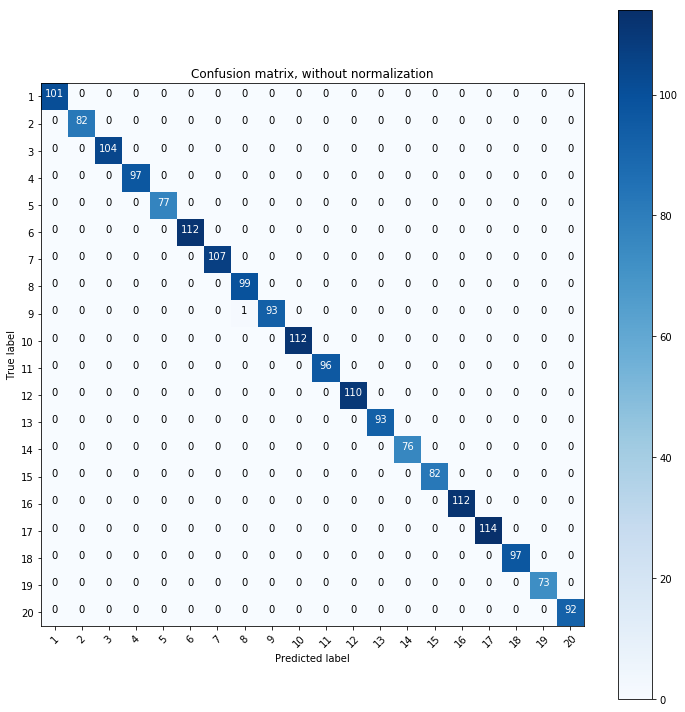

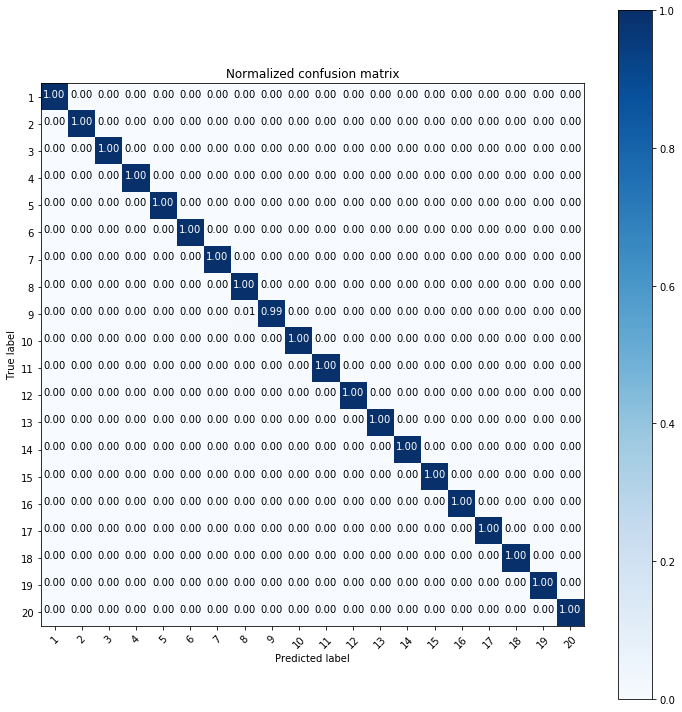

In [74]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:output_size]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix)) 
#we add one because the labels go from 0 to n-1 classes
print (class_names_matrix)
print_confusion_matrix(act_labels, pred_labels, output_size)

#### 3.3.2 Testing Error

In [128]:
correct = 0
total = 0
class_correct = list(0. for i in range(output_size))
class_total = list(0. for i in range(output_size))
actual_labels = []
predicted_labels = []

for data in test_data[0:76]:
    images, labels = data
    labels = labels - 1
    rnn.train(False)
    outputs = rnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    actual_labels.append(labels)
    predicted_labels.append(predicted)
    c = (predicted == labels).squeeze()
    for i in range(10):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

print('Accuracy of the network on the',len(test_data)*10,'test videos: %d %%' % (
    100 * correct / total))

for i in range(output_size):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i+1], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 760 test videos: 82 %
Accuracy of ApplyEyeMakeup : 81 %
Accuracy of ApplyLipstick : 65 %
Accuracy of Archery : 87 %
Accuracy of BabyCrawling : 88 %
Accuracy of BalanceBeam : 83 %
Accuracy of BandMarching : 95 %
Accuracy of BaseballPitch : 83 %
Accuracy of Basketball : 62 %
Accuracy of BasketballDunk : 100 %
Accuracy of BenchPress : 83 %
Accuracy of Biking : 89 %
Accuracy of Billiards : 100 %
Accuracy of BlowDryHair : 81 %
Accuracy of BlowingCandles : 90 %
Accuracy of BodyWeightSquats : 36 %
Accuracy of Bowling : 79 %
Accuracy of BoxingPunchingBag : 79 %
Accuracy of BoxingSpeedBag : 86 %
Accuracy of BreastStroke : 100 %
Accuracy of BrushingTeeth : 71 %


In [126]:
pred_labels = []
for item in predicted_labels:
    for i in item:
        pred_labels.append(i)
act_labels = []
for item in actual_labels:
    for i in item:
        act_labels.append(i)

{1: 'ApplyEyeMakeup', 2: 'ApplyLipstick', 3: 'Archery', 4: 'BabyCrawling', 5: 'BalanceBeam', 6: 'BandMarching', 7: 'BaseballPitch', 8: 'Basketball', 9: 'BasketballDunk', 10: 'BenchPress', 11: 'Biking', 12: 'Billiards', 13: 'BlowDryHair', 14: 'BlowingCandles', 15: 'BodyWeightSquats', 16: 'Bowling', 17: 'BoxingPunchingBag', 18: 'BoxingSpeedBag', 19: 'BreastStroke', 20: 'BrushingTeeth'}


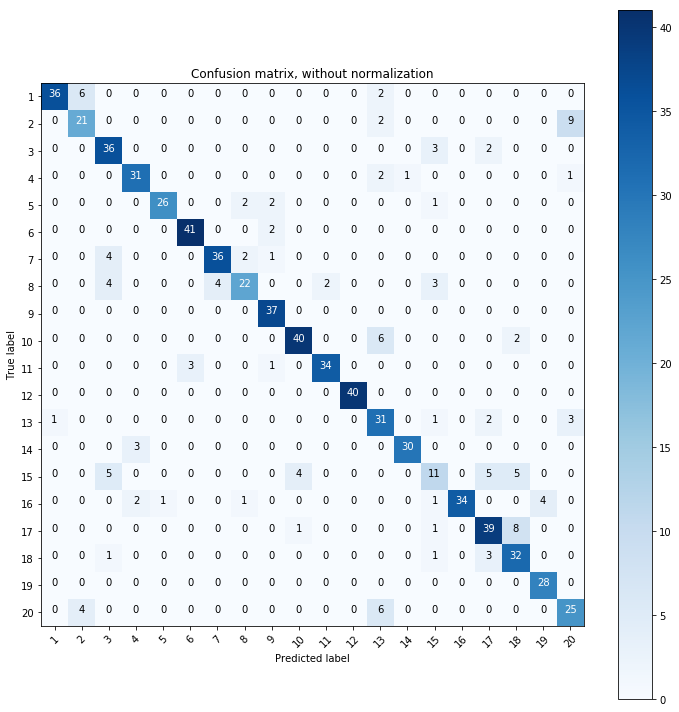

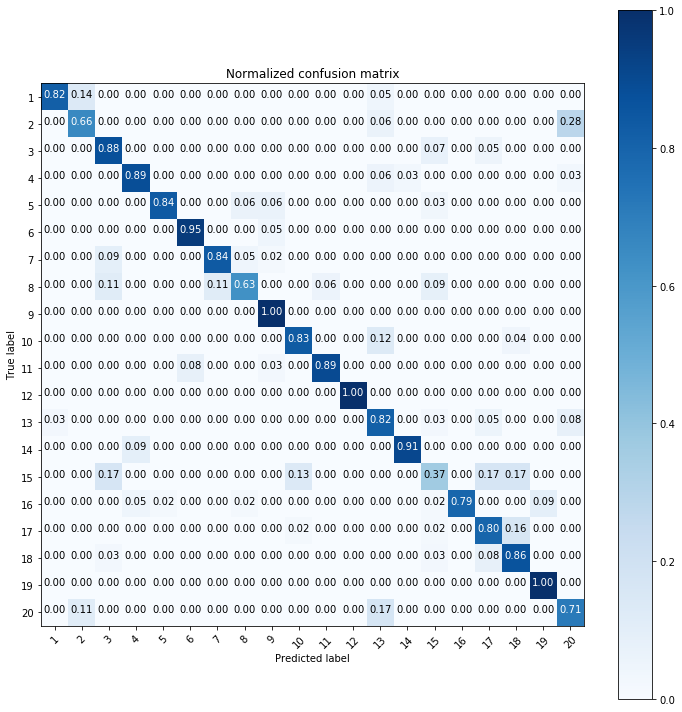

In [127]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:output_size]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix)) 
#we add one because the labels go from 0 to n-1 classes
print (class_names_matrix)
print_confusion_matrix(act_labels, pred_labels, output_size)


### 3.5 Save the Network
Here, we save the network and its parameters for future use.

In [122]:
# torch.save(rnn.state_dict(), 'plt_rnn.pkl') #save the network parameters
print("Model Saved")
x = RNN()
x.load_state_dict(torch.load('plt_rnn_1.pkl')) #load the model
print("Model Loaded")
print(x)

Model Saved
Model Loaded
RNN (
  (rnn): LSTM(4096, 64, num_layers=2, batch_first=True)
  (fc1): Linear (64 -> 20)
)


# 4. Evaluation
---
After training our network, we need to evaluate out model with the testing data by computing the prediction accuracy.


### 4.1 Summary of Training and Testing Error using the LSTM-Based RNN Classifier

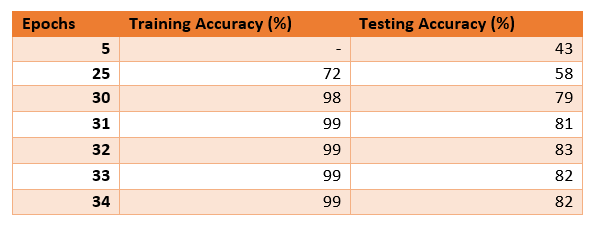

Here we see that, at epoch 5 and 25, the network is still underfitted because the training accuracy is still low.

We see some progress when we reach 30 epochs. With about 32 epochs, we get the highest testing accuracy. However, any more epoch after that tends to decrease the accuracy because the network started to overfit. So, about 32 epochs would be the best for the network. We can also introduce the decay rate for our optimiser so that the learning rate decreases and we can fit in more epochs for better accuracy.

### 4.2 Comparing with a SVM classifier

Here, we use another classifier, namely Support Vector Machine and see our accuracy using it.

However, as SVMs need data which are 1D so that it can make hyperplanes for each class, we need to change our 2D matrix to a 1D list. In this implementation, we stacked the 4096x25 feature matrix to a long vector and trained the SVM using that.

#### 4.2.1. Functions to change the feature matrix to a long vector

In [94]:
# function to extra features and labels into a long vector to train the SVM
def extract_list(batch_data):
    data = []
    rlabels = []
    for item in batch_data:
        feat, labels = item
        for i in feat:
            each = np.array(i.numpy())
            each = np.reshape(each, (len(each)*len(each[0])))
            data.append(each)
        for j in labels:
            rlabels.append(j)
    return data, rlabels

In [95]:
# extracting training data for SVM
train_data_svm, train_labels_svm = extract_list(train_data)
# extracting testing data for SVM
test_data_svm,test_labels_svm = extract_list(test_data)

### 4.3. Training the SVM

In [96]:
classifier_svm = svm.LinearSVC()

# As my machine is not capable of doing an SVM of all training data at once
# I am only taking a subset of it
# 0 to 1000 (excluded) has labels ranging from 1 to 11
# 0 to 1930 (excluded) has labels ranging from 1 to 20

train_length = 1930
train_svm = train_data_svm[0:train_length]
train_labels_input_svm = train_labels_svm[0:train_length]

s= time.clock()
print ("Training Started...")
classifier_svm.fit(np.array(train_svm), train_labels_input_svm) #fitting and training
print ("Training Finished...")
e = time.clock()
print ("Time Taken : " + str(e-s))

Training Started...
Training Finished...
Time Taken : 289.24001479109575


In [256]:
svm_save  = classifier_svm.get_params(True)
print (svm_save)

{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


### 4.4. Test the SVM

#### 4.4.1. Training Accuracy

In [111]:
# method for getting accuracy when a train label set and test label set is passed
def get_accuracy(actual_label, predicted_label):
    accuracy = sum(np.array(actual_label) == predicted_label) / float(len(actual_label))
    return accuracy

In [112]:
# training accuracy
predicted_train_labels_svm = classifier_svm.predict(train_svm) # getting the predicted labels
S = get_accuracy(train_labels_input_svm , predicted_train_labels_svm) # getting the accuracy
print ("The training accuracy of my model using SVM is {:.2f}%".format(S*100))

The training accuracy of my model using SVM is 100.00%


{1: 'ApplyEyeMakeup', 2: 'ApplyLipstick', 3: 'Archery', 4: 'BabyCrawling', 5: 'BalanceBeam', 6: 'BandMarching', 7: 'BaseballPitch', 8: 'Basketball', 9: 'BasketballDunk', 10: 'BenchPress', 11: 'Biking', 12: 'Billiards', 13: 'BlowDryHair', 14: 'BlowingCandles', 15: 'BodyWeightSquats', 16: 'Bowling', 17: 'BoxingPunchingBag', 18: 'BoxingSpeedBag', 19: 'BreastStroke', 20: 'BrushingTeeth'}


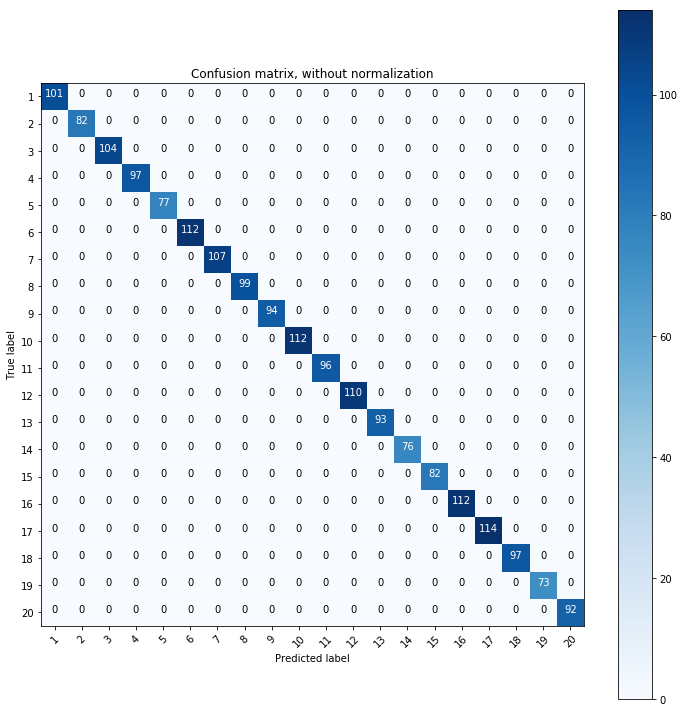

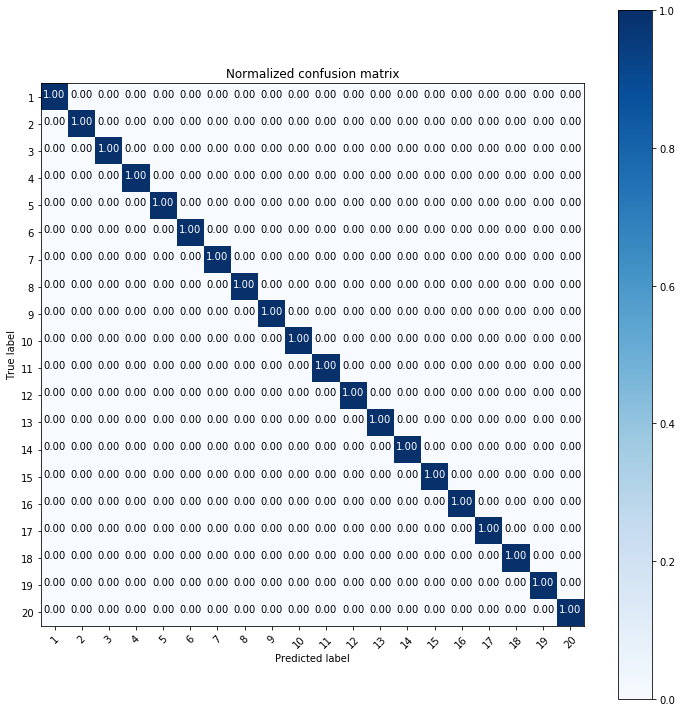

In [114]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:output_size]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(train_labels_input_svm, predicted_train_labels_svm, 20)

#### 4.4.2. Testing Accuracy

In [97]:
# As test data has less samples than training data
# we need to take a smaller subset of the training data
# 0 to 400 (excluded) has labels ranging from 1 to 11
# 0 to 760 (excluded) has labels ranging from 1 to 20

test_length = 760
test_svm = test_data_svm[0:test_length]
test_labels_input_svm = test_labels_svm[0:test_length]

In [99]:
predicted_test_labels_svm = classifier_svm.predict(test_svm) # getting the predicted labels
S = get_accuracy(test_labels_input_svm , predicted_test_labels_svm) # getting the accuracy
print ("The testing accuracy of my model using SVM is {:.2f}%".format(S*100))

The testing accuracy of my model using SVM is 92.76%


{1: 'ApplyEyeMakeup', 2: 'ApplyLipstick', 3: 'Archery', 4: 'BabyCrawling', 5: 'BalanceBeam', 6: 'BandMarching', 7: 'BaseballPitch', 8: 'Basketball', 9: 'BasketballDunk', 10: 'BenchPress', 11: 'Biking', 12: 'Billiards', 13: 'BlowDryHair', 14: 'BlowingCandles', 15: 'BodyWeightSquats', 16: 'Bowling', 17: 'BoxingPunchingBag', 18: 'BoxingSpeedBag', 19: 'BreastStroke', 20: 'BrushingTeeth'}


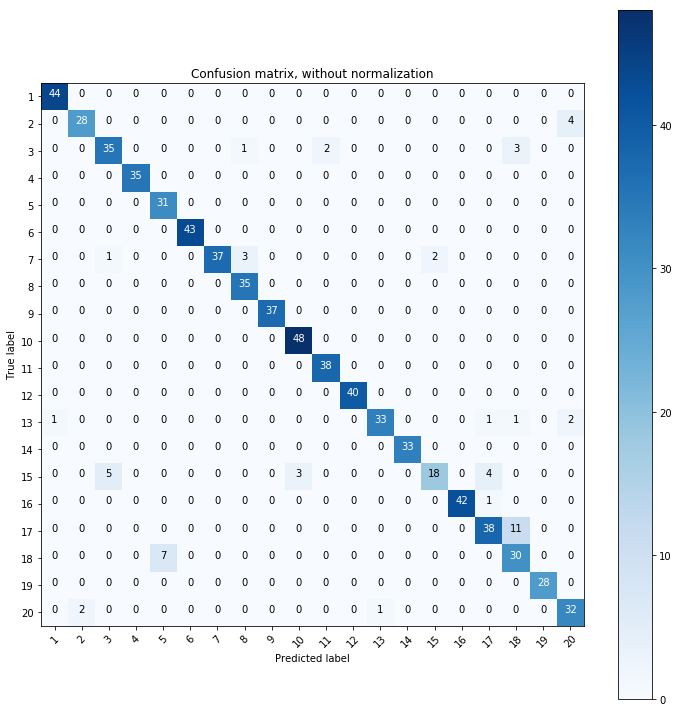

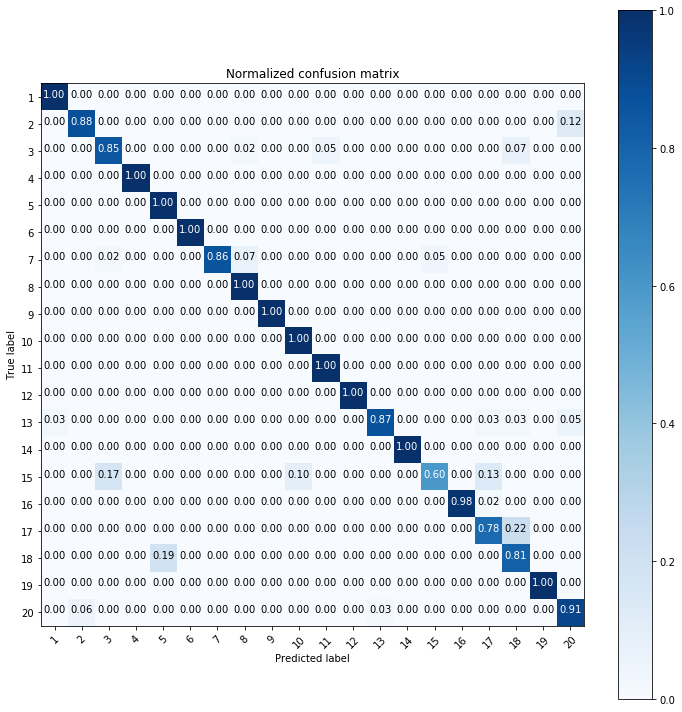

In [102]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:20]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(test_labels_input_svm, predicted_test_labels_svm, 20)

## 5. Conclusion

This experiment can be seen as a perfect example of how the nature of a  feature representation matters, whether we are using a really complex classifier like a LSTM-Based RNN or a comparatively simpler classifier like SVM.

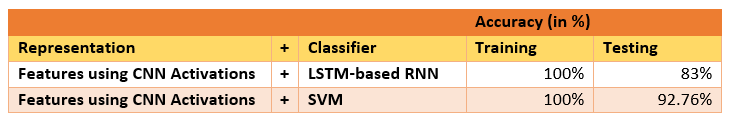

It is always said in class that using a smart feature representation with a simple classifier is better than using a simple feature representation with a smart classifier.

Here, SVM is much simpler than LSTM-based RNN, but it still outperforms the RNN by approximately 10%. Another reason that the RNN performed worse was because we didn't have enough training data for a single class. We tended to have more classes but less samples per class. One way to reduce this would be by augmenting data but because we have sequential data with various actions, the usual data augmentation using  mirror should be done very carefulling. But it would still not be computationally efficient because we need to get the mirror image's feature representation using the customized VGG.

To tackle this, for some appropriate videos which are the essentially same while playing backwards like *playing a guitar/sitar*, *putting tabla* and so on, we can just reverse their feature representation which will then augment the data without relying much on the computationally heavy VGG feature extractor.

#### Confusion Matrix of Test Data for LSTM-based Classifier
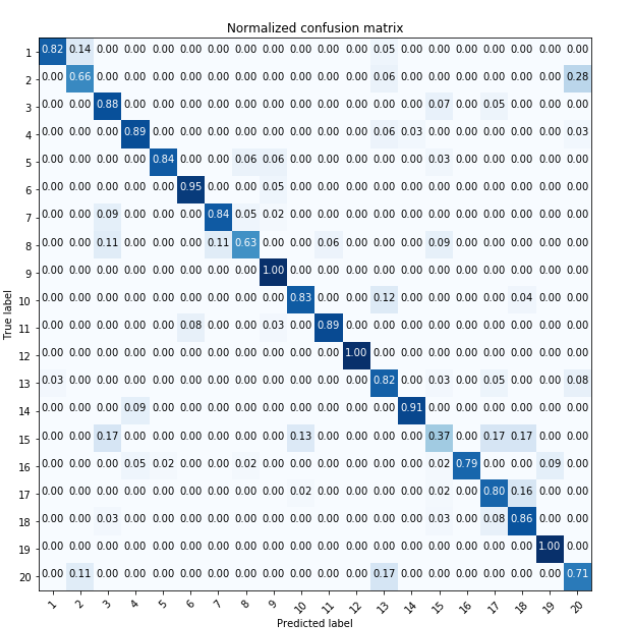

#### Confusion Matrix of Test Data for SVM Classifier
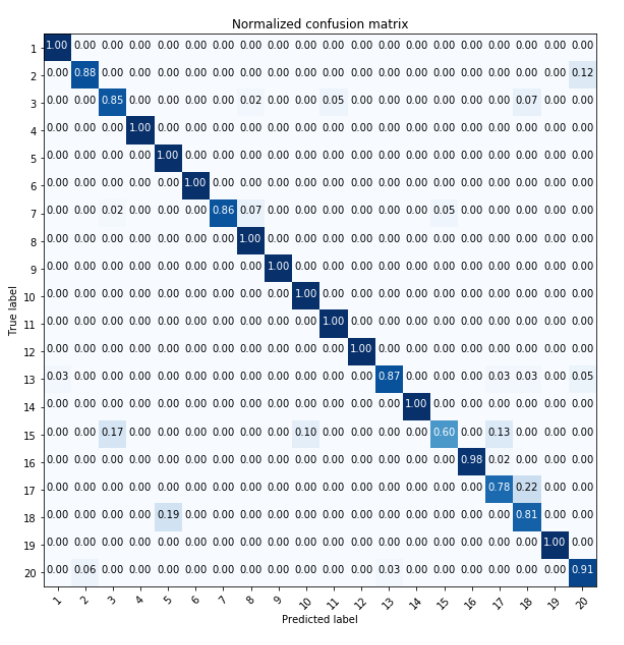

Another thing to notice using the confusion matrices is that, SVM is very consistent compared to LSTM-based RNN. Accuracy for SVM ranges from 78% to 100% whereas LSTM ranges from 37% to 100%. This means that the predictions from SVM are much more reliable than that from LSTM.

In short, even though RNNs look very tedious and uninteresting at first, the real-life implementations of it are very profound whether it be natural language processing or action recognition or language translation and so on. So, learning how it works, knowing its advantages, disadvantages and having experience with it is important. Similarly, sometimes knowing a simpler but efficient implementation is also necessary to do minor tasks or double check your work.

**Thank you for reading until the end!!!!**

---
Credits for the dataset: [UCF: Center for Research in Computer Vision](http://crcv.ucf.edu/data/UCF101.php) (2013)